# Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from NCA.NCA import *
import NCA.utils as utils
from IPython.display import clear_output
import logging
import os

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# Initial Setup 

In [2]:
DEVICE = "cuda:0" #<--- if no GPU change to "cpu"
HEIGHT = 50
WIDTH = 50
CHANNELS = 16 #<--- NCA feature channels
BATCH_SIZE = 16
MASKING = 0
POOL_SIZE = 8000 #<--- NCA training pool size, lower values train faster but are less stable 
TRAINING_ITERS = 14000 
PATH_TO_IMAGE = "../Images/lizard.png" #<--- image to grow 
IMAGE_NAME = "Lizard" #<--- name of image for saving purposes 

# Reference Image & Visualisation

In [3]:
reference_image,seed = utils.get_reference_image_and_seed(PATH_TO_IMAGE, HEIGHT,WIDTH,CHANNELS)


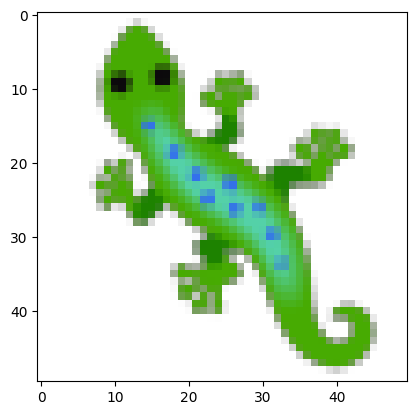

In [4]:
plt.figure(3)
plt.imshow(utils.to_vue_image(reference_image))

# Filters for Loss Function, NCAs to Test, Masking Levels to Test 

In [5]:
sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]], dtype=torch.float32, device="cuda:0")
lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]], dtype=torch.float32, device="cuda:0")
filters = torch.stack([sobel_x, sobel_x.T, lap])
folders = []
ncas = [DummyVCA,MaskedCA,ReducedCA]   #<--- NCAs to test 
maskings = [0,1,2,3,4,5,6,7,8,9,10,11,12] #<--- masking levels to test 

# Dirr Setup for Saving Models and Experimental Data 

In [6]:
for nca_type in ncas:
    nca = nca_type(1,1,1) #dummy nca to get name 
    path = "Trained_models/" + IMAGE_NAME +"/"+ type(nca).__name__ 
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Path: {path} created")
    else: 
        print(f"Path: {path} already exists, all OK!")
    folders.append(path)

for nca_type in ncas:
    nca = nca_type(1,1,1) #dummy nca to get name 
    path = "Saved_Data/" + IMAGE_NAME +"/"+ type(nca).__name__ 
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Path: {path} created")
    else: 
        print(f"Path: {path} already exists, all OK!")
    folders.append(path)


Path: Trained_models/Lizard/DummyVCA created
Path: Trained_models/Lizard/MaskedCA created
Path: Trained_models/Lizard/ReducedCA created
Path: Saved_Data/Lizard/DummyVCA created
Path: Saved_Data/Lizard/MaskedCA created
Path: Saved_Data/Lizard/ReducedCA created


# Experiment 

Trained_models/Lizard/ReducedCA/ReducedCA_padding_10


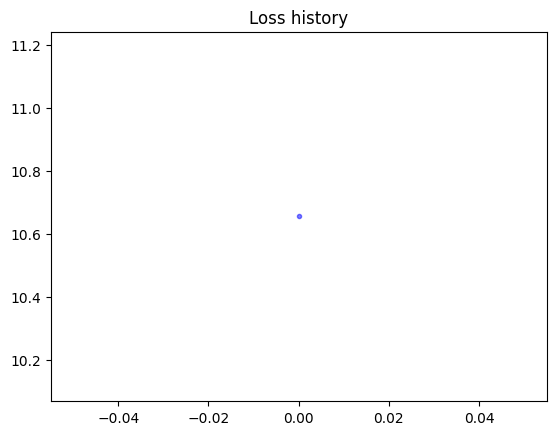

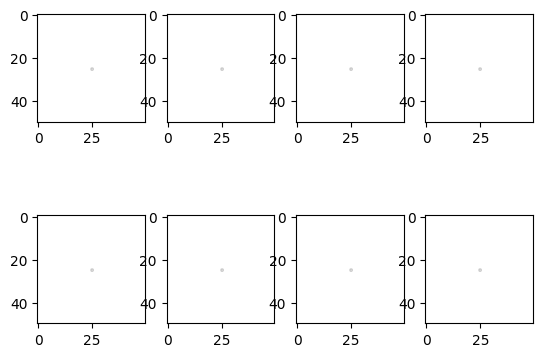

KeyboardInterrupt: 

In [7]:
for ncax, folder in zip(ncas,folders):
    for masking in maskings:

        pool = torch.tile(seed, (POOL_SIZE, 1, 1, 1))
        loss_log = []
        nca = ncax(CHANNELS,96, masking)
        nca = nca.to(DEVICE)
        optim = torch.optim.AdamW(nca.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2500, gamma=0.3)
        name = folder + "/" +type(nca).__name__ + "_padding_" +str(masking)
        for i in range(TRAINING_ITERS + 1):
            loss = 0
            with torch.no_grad():
                x, idxs = utils.get_batch(pool, seed, BATCH_SIZE)
                
            for _ in range( random.randrange(32,92)):
                x = nca(x)
                
            loss = (reference_image[None,...] - x[:, :4, :, :]).pow(2).sum() + 0.1 * (perchannel_conv(reference_image[None,...], filters) - perchannel_conv(x[:, :4, :, :], filters)).pow(2).sum() 
            
            with torch.no_grad():
                loss.backward()
                for p in nca.parameters():
                    p.grad /= (p.grad.norm() + 1e-8)
                optim.step()
                x = x.detach()
                optim.zero_grad()
            
            loss_log.append(loss.log().item())
            pool = utils.update_pool(pool, x.clone().detach(), idxs)
            scheduler.step()
           
            if i % 100 == 0:
                print(f"Training itter {i}, loss = {loss.item()}")
                plt.clf()
                clear_output()
                plt.figure(1,figsize=(10, 4))
                plt.title('Loss history')
                print(name)
                plt.plot(loss_log, '.', alpha=0.5, color = "b")
                utils.show_batch(x)
                plt.show(block=False)
                plt.pause(0.01)
            if i % 100 == 0:
                torch.save(nca.state_dict(),  name + ".pth")
        
        save_data_path = name.replace("Trained_models/","Saved_Data/")
        np_logg = np.asarray(loss_log)
        np.save( save_data_path + "_data", np_logg)
